# Neural Network-based Part of Speech Tagger

In this problem, we will
- Build a neural network based part of speech (POS) tagger.
- Run the model on a GPU at Google Colab.
- Extend the model to use pretrained embeddings.
- Optionally extend the model in some manner of your own choosing.

There are a total of 8 tasks.

Acknowledgements: Part of this homework were adapted from work done by
[Ben Trevett](https://github.com/bentrevett) and
[Kevin Gimpel](https://home.ttic.edu/~kgimpel/).

In [12]:
!pip install torchtext==0.9.0

distutils: c:\users\hocke\appdata\local\programs\python\python39\Include\UNKNOWN
sysconfig: c:\users\hocke\appdata\local\programs\python\python39\Include
user = False
home = None
root = None
prefix = None
distutils: c:\users\hocke\appdata\local\programs\python\python39\Include\UNKNOWN
sysconfig: c:\users\hocke\appdata\local\programs\python\python39\Include
user = False
home = None
root = None
prefix = None
You should consider upgrading via the 'c:\users\hocke\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim

# import torchtext
# torchtext.__version__
from torchtext import data
from torchtext import datasets

from collections import Counter
from torchtext.vocab import Vocab

import numpy as np
import random


In [14]:
SEED = 53113 # Specify a seed for reproducability

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Using GPUs

We want our code to run on a CPU or on a [GPU](https://en.wikipedia.org/wiki/Graphics_processing_unit) when available, as on Google Colab.  The code will likely run at least five times as fast on a GPU. PyTorch connects with a GPU via the system interface [CUDA](https://en.wikipedia.org/wiki/CUDA).

The following tells us whether CUDA/GPU is available or not.  The changes you have to make so that your code can use a GPU when available are surprisingly small. All such changes have already been made in the provided code below. They are:
- the data loader needs to place the input to the model appropriately using `to(device).`
- similarly, the model object itself needs to be placed appropriately using `to(device).`


In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Cache for GloVe

If you have already downloaded GloVe in a directory, you can reuse it.  Please change the following if so, else choose None.

In [16]:
if device == 'cpu':
    VECTORS_CACHE_DIR = '/Users/hocke/.vector_cache'
    # Please change above to your cache
else:
    VECTORS_CACHE_DIR = './.vector_cache'
    # This is the default cache on Colab. Caching may not work
    # as expected on Colab.
    
# VECTORS_CACHE_DIR = None

### UDPOS Dataset

We'll work with the [`UDPOS`](https://pytorch.org/text/stable/datasets.html#udpos) dataset included with torchtext.  It contains about 12,500 sentences and the POS tags for the each word.  There are, in fact, two sets of tags, based on two different POS tagging standards: [Universal Dependency](https://universaldependencies.org/u/pos/) (UD) and [Penn Treebank](https://www.sketchengine.eu/penn-treebank-tagset/) (PTB). It has additionally about 2000 sentences in the validation and test sets.  The words and corresonding tags are organized into lists.

In [17]:
train_iter = datasets.UDPOS(split = 'train')

for i, example in enumerate(train_iter):
    print(f'The sentence for Example {i} ---')
    print(example[0])
    print(f'The UD tags for Example {i} ---')
    print(example[1])
    print(f'The PTB tags for Example {i} ---')
    print(example[2])
    print()
    if i == 2: break

The sentence for Example 0 ---
['Al', '-', 'Zaman', ':', 'American', 'forces', 'killed', 'Shaikh', 'Abdullah', 'al', '-', 'Ani', ',', 'the', 'preacher', 'at', 'the', 'mosque', 'in', 'the', 'town', 'of', 'Qaim', ',', 'near', 'the', 'Syrian', 'border', '.']
The UD tags for Example 0 ---
['PROPN', 'PUNCT', 'PROPN', 'PUNCT', 'ADJ', 'NOUN', 'VERB', 'PROPN', 'PROPN', 'PROPN', 'PUNCT', 'PROPN', 'PUNCT', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'PROPN', 'PUNCT', 'ADP', 'DET', 'ADJ', 'NOUN', 'PUNCT']
The PTB tags for Example 0 ---
['NNP', 'HYPH', 'NNP', ':', 'JJ', 'NNS', 'VBD', 'NNP', 'NNP', 'NNP', 'HYPH', 'NNP', ',', 'DT', 'NN', 'IN', 'DT', 'NN', 'IN', 'DT', 'NN', 'IN', 'NNP', ',', 'IN', 'DT', 'JJ', 'NN', '.']

The sentence for Example 1 ---
['[', 'This', 'killing', 'of', 'a', 'respected', 'cleric', 'will', 'be', 'causing', 'us', 'trouble', 'for', 'years', 'to', 'come', '.', ']']
The UD tags for Example 1 ---
['PUNCT', 'DET', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', 'AUX',

### Preprocessing

In our neural network-based model we can only accept fixed sized inputs.  Each input corresponds to a subsequence, consisting of a  center word and a number $w$ of words before and after, and the label is the POS tag for the center word. We often refer to the subsequence as a window of size $(2w + 1)$.

So given a sentence, say, "This killing of a respected cleric.' with, tags, say 'DET', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', 'PUNCT' (the last tag is for the period at the end of the sentence), some of our input examples for the model are the following (for $w = 1$):
- "This killing of", 'NOUN'
- "killing of a", 'ADP'
- "respected cleric.", 'NOUN'.

But the above scheme would imply that, when $w = 1$, the tags of the first and last words for any sentence would never be part of an example.  To avoid that, we add dummy '\<s>' and '\</s>' words, and corresponding tags, to the beginning and end of each sentence.  We need to add as many dummy words as $w$.  So if $w = 2$, we first convert the above sentence and its tags to
- "\<s> \<s> This killing of a respected cleric. \</s> \</s>' 
- 'STAG', 'STAG','DET', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', 'PUNCT', 'ETAG', 'ETAG'. 

**Task 1** [5 points]: Most of the code for preprocessing is given below.  But some parts are missing.  Complete the code.

In [18]:
W = 1 # Number of words before and after
WINDOW_SIZE = (2 * W + 1) # total number of words in the window

SENT_START_WORD = '<s>'
SENT_END_WORD = '</s>'
SENT_START_TAG = '<STAG>'
SENT_END_TAG = '<ETAG>'


def add_sent_start_end(data_iter, w):
    for (words, ud_tags, ptb_tags) in data_iter:
        new_words = [SENT_START_WORD] * w + words + [SENT_END_WORD] * w
        new_ud_tags = [SENT_START_TAG] * w + ud_tags + [SENT_END_TAG] * w
        ## MISSING PART: ADD YOUR CODE BELOW
        new_ptb_tags = [SENT_START_TAG] * w + ptb_tags + [SENT_END_TAG] * w
        ## ADD YOUR CODE ABOVE
        yield(new_words, new_ud_tags, new_ptb_tags)
        
def create_windows(data_iter, w):
    window_size = 2*w + 1
    for (words, ud_tags, ptb_tags) in data_iter:
        words_zip = zip(*[words[i:] for i in range(window_size)])
        ud_zip = zip(*[ud_tags[i:] for i in range(window_size)])
        ## MISSING PART: ADD YOUR CODE BELOW
        ptb_zip = zip(*[ptb_tags[i:] for i in range(window_size)])
        ## ADD YOUR CODE ABOVE
        for word_sseq, ud_sseq, ptb_sseq in zip(
                words_zip, ud_zip, ptb_zip):
            yield(word_sseq, ud_sseq, ptb_sseq)
            
def preprocess_data_seq(data_iter, w):
    ## MISSING PART: ADD YOUR CODE BELOW
    data_iter = add_sent_start_end(data_iter, w)
    return create_windows(data_iter, w)

def test_preprocess_data_seq():
    # WARNING: The following test assumes a particular default
    # sequence of examples in the PyTorch UDPOS dataset. If you
    # suspect the sequence is different for your dataset, please
    # adapt the test.
    train_iter_0 = datasets.UDPOS(split = 'train')    
    train_iter_demo = preprocess_data_seq(train_iter_0, 1)
    ex0 = (('<s>', 'Al', '-'), 
           ('<STAG>', 'PROPN', 'PUNCT'), 
           ('<STAG>', 'NNP', 'HYPH'))
    ex1 = (('Al', '-', 'Zaman'), 
           ('PROPN', 'PUNCT', 'PROPN'), 
           ('NNP', 'HYPH', 'NNP'))
    ex2 = (('-', 'Zaman', ':'), 
           ('PUNCT', 'PROPN', 'PUNCT'), 
           ('HYPH', 'NNP', ':'))
    assert ex0 == next(train_iter_demo)
    assert ex1 == next(train_iter_demo)
    assert ex2 == next(train_iter_demo)

    print('Test passed.')
    
test_preprocess_data_seq()


Test passed.


In [19]:
# It is important to recreate the training set afresh 
# each time they are used, since they are Python iterators, and
# once use, cannot be reused.  One could, however, cast them into
# a list, which would store them permanently.

from torchtext import vocab
train_iter_0 = datasets.UDPOS(split = 'train')    
train_iter_vocab = preprocess_data_seq(train_iter_0, 1)

counter_words = Counter()
counter_ud = Counter()
counter_ptb = Counter()
for (text, pos_ud, pos_ptb) in train_iter_vocab:
    counter_words.update(text)
    counter_ud.update(pos_ud)
    counter_ptb.update(pos_ptb)
vocab_words = Vocab(counter_words)    
vocab_ud = Vocab(counter_ud)
vocab_ptb = Vocab(counter_ptb)


glove = vocab.GloVe('6B', cache=VECTORS_CACHE_DIR)
glove_vectors = glove.get_vecs_by_tokens(vocab_words.itos)


### Collate function for customized data loader

**Task 2** [5]: Write a collate function that takes a batch of examples, and for a given window width and tag type, returns the following
- a tensor corresponding to the index of the tag for the center word in each example of the batch. Recall, each example is a window with a width of $(2w + 1)$ words.
- a tensor corresponding to the index of each of the words in the example, according the to vocabulary for words.

Note: The collate function is called by the data loader with the batch of examples from the data set.  So any additional parameters to the function should have default values.

From this task onwards we'll only work with the UD tags.

In [20]:
from torch.utils.data import DataLoader

TAG = 'ud'

def collate_fn(batch, w = W, tag = TAG):
    ## WRITE YOUR CODE BELOW
    # print(w, batch)
    mid = w  # this is always the case because the window size is an odd number and list is 0-indexed.
    labels = []
    word_idxs = []
    for (words, ud_tags, ptb_tags) in batch:
        labels.append(vocab_ud[ud_tags[mid]])
        word_idx = []
        for word in words:
            word_idx.append(vocab_words[word])
        word_idxs.append(word_idx)
    labels = torch.tensor(labels)
    word_idxs = torch.tensor(word_idxs)
    ## WRITE YOUR CODE ABOVE
    # The tensors you return should be place in the correct device
    # as shown below.
    return labels.to(device), word_idxs.to(device)

def test_collate():
    pos = [5, 6, 1, 4]  
    examples = []
    # print(vocab_words.itos[])
    for perm in ['03022', '33210', '33211', '11101']:
        words = []
        utags = []
        ptags = []
        for ind in perm:
            ind = int(ind)
            # print(ind, perm, pos[ind], pos[ind]+1, vocab_words.itos, vocab_ud.itos, vocab_ptb.itos)
            words.append(vocab_words.itos[pos[ind]])
            utags.append(vocab_ud.itos[pos[ind]+1]) 
            ptags.append(vocab_ptb.itos[pos[ind]]) 
            # print(pos[ind])
        examples.append((words, utags, ptags))
    lt =  torch.tensor([6, 2, 2, 7]).to(device)
    wt = torch.tensor([
        [5, 4, 5, 1, 1],
        [4, 4, 1, 6, 5],
        [4, 4, 1, 6, 6],
        [6, 6, 6, 5, 6]]).to(device)  # original

    rlt, rwt = collate_fn(examples, w = 2)
    assert torch.equal(lt, rlt)
    assert torch.equal(wt, rwt)

test_collate()
    


### Writing the class for the neural network model

**Task 3** [5]: Write a class that implements the following neural network for input $(w_1, w_2, w_3)$ and label $y$ corresponding to tag of $w_2$. (Also discussed in class on April 15, 2021).
$$
x = [E_{[w_1]}, E_{[w_2]}, E_{[w_3]}] \\
h = \text{tanh}(x W^1 + b^1)\\
\tilde{y} = hW^2 + b^2\\
\hat{y} = \text{softmax}(y)\\
$$
The model returns $\ln \hat{y}$, and expects the training loop to use `nn.NLLLoss()` to compute the cross entropy loss, given $y$. Assume the embedding has vectors of size $300$, and $h$ is a vector of size $128$.  Please read the documentation for `nn.Embedding(),` `nn.Linear(),`, and `nn.Tanh()` to learn how to use them.

*Hint:* Unlike HW2, here the input (for each example in a batch) consist of $(2w+1)$ numbers corresponding to the indices of the words in the window. These are converted to $(2w+1)$ vectors when they are passed to the embedding layer. They have to be concatenated into a single vector of length $(2w+1) \times 300$ before they are sent to the first linear layer ($W^1$).  Use `reshape()` or `view()` in the `forward()` function below to achieve this.


In [21]:
import torch.nn.functional as F

class NNPOSTagger(nn.Module):
    def __init__(self,
                 window_size,
                 vocab_size, 
                 embedding_dim, 
                 hidden_dim, 
                 output_dim,
                 nonlinearity, 
                 # These are used for later tasks
                 use_glove, 
                 freeze_glove):      
        super(NNPOSTagger, self).__init__()
        ## WRITE YOUR CODE BELOW
        self.pretrained_embeddings = nn.Embedding.from_pretrained(glove_vectors, freeze=freeze_glove)
        self.embeddings = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        self.linear1 = nn.Linear(in_features=window_size * embedding_dim, out_features=hidden_dim)
        self.linear2 = nn.Linear(in_features=hidden_dim, out_features=output_dim)
        self.tanh = nonlinearity
        self.use_glove = use_glove
        self.freeze_glove = freeze_glove
        
    def forward(self, word_idxs_batch):
        ## WRITE YOUR CODE BELOW.
        if self.use_glove:
            # embedding = self.embeddings.from_pretrained(glove_vectors, freeze=self.freeze_glove)
            x = self.pretrained_embeddings(word_idxs_batch)
            # concatenate each of the embedded vectors into one long vector
            x = x.reshape(x.shape[0], x.shape[1]*x.shape[2])
        else:
            x = self.embeddings(word_idxs_batch)
            # concatenate each of the embedded vectors into one long vector
            x = x.reshape(x.shape[0], x.shape[1]*x.shape[2])

        h = self.tanh(self.linear1(x))
        y_tilde = self.linear2(h)
        y_hat = F.softmax(y_tilde, dim=1)

        return y_hat



#### Instantiating the model

PyTorch uses `to(device)` to specify whether the model is to be used with a CPU or with a GPU/CUDA.

In [22]:
model = NNPOSTagger(window_size = WINDOW_SIZE, 
                    vocab_size = len(vocab_words), 
                     embedding_dim = 300, 
                     hidden_dim = 128, 
                     output_dim = len(vocab_ud),
                     nonlinearity = nn.Tanh(), 
                     use_glove = False,
                     freeze_glove = False).to(device)


AssertionError: Embeddings parameter is expected to be 2-dimensional

### Training an epoch

**Task 4** [5]: Write a function to train one epoch of the dataset. This is similar to the code in HW2.

In [ ]:
import time 

loss_function = torch.nn.NLLLoss() # negative log likelihood

def train_an_epoch(dataloader):
    ### WRITE YOUR CODE BELOW
    model.train()  # Sets the module in training mode.
    log_interval = 500

    for idx, (label, text) in enumerate(dataloader):
        model.zero_grad()  # reset gradients to zero since torch accumulates gradients.
        log_probs = model(text)  # run forward pass
        loss = loss_function(log_probs, label)
        loss.backward() # run backward pass to update the gradient
        optimizer.step()
        if idx % log_interval == 0 and idx > 0:
            print(f'At iteration {idx} the loss is {loss:.3f}.')

In [ ]:
model.eval()

NNPOSTagger(
  (pretrained_embeddings): Embedding(19676, 300)
  (embeddings): Embedding(19676, 300)
  (linear1): Linear(in_features=900, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=21, bias=True)
  (tanh): Tanh()
)

### Computing the accuracy

The function is given below.

In [ ]:
def get_accuracy(dataloader):
    model.eval()
    with torch.no_grad():    
        total_acc, total_count = 0, 0
        for idx, (label, word_idxs) in enumerate(dataloader):
            log_probs = model(word_idxs)
            total_acc += (log_probs.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count

### Creating the data loaders

In [ ]:
BATCH_SIZE = 64 # batch size for training
  
train_0, valid_0, test_0 = train_data_0 = datasets.UDPOS(
    split = ('train', 'valid', 'test'))
train_data = list(preprocess_data_seq(train_0, W))
valid_data = list(preprocess_data_seq(valid_0, W))
test_data = list(preprocess_data_seq(test_0, W))

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE,
                              shuffle=True, 
                              collate_fn=collate_fn)
valid_dataloader = DataLoader(valid_data, batch_size=BATCH_SIZE,
                              shuffle=False, 
                              collate_fn=collate_fn)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE,
                             shuffle=False, 
                             collate_fn=collate_fn)

### Training

At iteration 500 the loss is -0.505.
At iteration 1000 the loss is -0.653.
At iteration 1500 the loss is -0.693.
At iteration 2000 the loss is -0.733.
At iteration 2500 the loss is -0.707.
At iteration 3000 the loss is -0.726.
Epoch: 1, time taken: 127.8s, validation accuracy: 0.685.
At iteration 500 the loss is -0.656.
At iteration 1000 the loss is -0.725.
At iteration 1500 the loss is -0.770.
At iteration 2000 the loss is -0.798.
At iteration 2500 the loss is -0.740.
At iteration 3000 the loss is -0.800.
Epoch: 2, time taken: 146.5s, validation accuracy: 0.738.
At iteration 500 the loss is -0.803.
At iteration 1000 the loss is -0.705.
At iteration 1500 the loss is -0.833.
At iteration 2000 the loss is -0.823.
At iteration 2500 the loss is -0.770.
At iteration 3000 the loss is -0.792.
Epoch: 3, time taken: 146.2s, validation accuracy: 0.763.


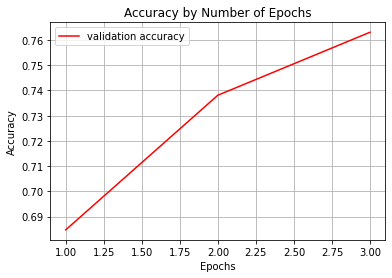

In [ ]:
import time
import matplotlib.pyplot as plt
%matplotlib inline

EPOCHS = 30 # epoch
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

accuracies=[]
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train_an_epoch(train_dataloader)
    accuracy = get_accuracy(valid_dataloader)
    accuracies.append(accuracy)
    time_taken = time.time() - epoch_start_time
    print(f'Epoch: {epoch}, time taken: {time_taken:.1f}s, validation accuracy: {accuracy:.3f}.')
    
plt.title("Accuracy by Number of Epochs")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.grid()
plt.plot(range(1, EPOCHS+1), accuracies, "r", label="validation accuracy")
plt.legend()
plt.savefig(f"POSValidationAccuracy{EPOCHS}epochs.jpg")


### Running on Google Colab

Google Colab provides GPUs on which we can run Jupyter notebooks. These are for free as long as the job takes less than, say, 4 hours. Our job will take much less.

Please create an account on Google if you don't have one.  Please read a tutorial on using Colab (such as [this](https://colab.research.google.com/notebooks/intro.ipynb)).  Upload your notebook on Colab. **Change the runtime type to GPU.** Make any changes required to get your code to run on Colab. (Normally there should  be no change required.) 

For all following tasks that required running your code for several epochs, we recommend developing your code locally, but finally running it on Colab to get the results.

**Task 5** [5]: Run the model for a sufficient number of epochs (not more than 30) such that the model shows overfitting, if at all, and submit a pdf of the plot of accuracy against number of epochs. Determine the optimal number of epochs to train for. Write code to estimate the accuracy of your model (using the test set) corresponding to this optimal number of epocs and report this estimated accuracy.

### Initializing with pre-trained embeddings

In the above model, the embedding matrix is initialized to either zero or random vectors, but trained along with the rest of the parameters. It may help to initialize the embedding matrix from GloVe vector embeddings. You may then choose to freeze the embedding matrix (i.e., not update the vectors during training) or train them to adapt to the POS examples. (For further details you may optionally read Section 10.1--3 from the Goldberg textbook.)

The following code snippet creates a embedding matrix that has a vector corresponding to each of our `vocab_words` created from the training set.

In [ ]:
from torchtext import vocab

glove = vocab.GloVe('6B', cache=VECTORS_CACHE_DIR)
glove_vectors = glove.get_vecs_by_tokens(vocab_words.itos)

**Task 6** [5]: Rewrite/extend the code for the module to initialize the embedding layer with `glove_vectors` created above.  Please read the documentation for the function [`nn.Embedding.from_pretrained()`](https://pytorch.org/docs/master/generated/torch.nn.Embedding.html#torch.nn.Embedding.from_pretrained) to understand how this is done. Submit corresponding plot and report on the performance when the embedding is frozen.

**Task 7** [5]: Submit corresponding plot and report on the performance when the embedding is not frozen.

In [ ]:
'''
Tasks 6 and 7:
The performance of the frozen embeddings is noteably quicker. On my local machine, 
training took approximately 4 seconds per epoch for the frozen embeddings, 
while the other embeddings took approximately 145 seconds per epoch. 
This intuitively makes sense since no vector update is performed during each iteration 
of the frozen embedding matrix training model.
'''


At iteration 500 the loss is -0.356.
At iteration 1000 the loss is -0.430.
At iteration 1500 the loss is -0.660.
At iteration 2000 the loss is -0.553.
At iteration 2500 the loss is -0.668.
At iteration 3000 the loss is -0.590.
Epoch: 1, time taken: 4.0s, validation accuracy: 0.634.
At iteration 500 the loss is -0.624.
At iteration 1000 the loss is -0.631.
At iteration 1500 the loss is -0.694.
At iteration 2000 the loss is -0.649.
At iteration 2500 the loss is -0.699.
At iteration 3000 the loss is -0.668.
Epoch: 2, time taken: 4.1s, validation accuracy: 0.685.
At iteration 500 the loss is -0.673.
At iteration 1000 the loss is -0.684.
At iteration 1500 the loss is -0.688.
At iteration 2000 the loss is -0.735.
At iteration 2500 the loss is -0.693.
At iteration 3000 the loss is -0.690.
Epoch: 3, time taken: 4.3s, validation accuracy: 0.699.


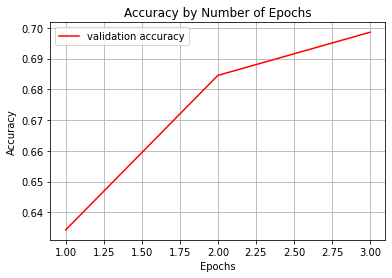

In [ ]:
### Use Glove Pretrained Embeddings - FROZEN ###
model_pretrained_frozen = NNPOSTagger(window_size=WINDOW_SIZE,
                                      vocab_size=len(vocab_words),
                                      embedding_dim=300,
                                      hidden_dim=128,
                                      output_dim=len(vocab_ud),
                                      nonlinearity=nn.Tanh(),
                                      use_glove=True,
                                      freeze_glove=True).to(device)

optimizer_pretrained_frozen = torch.optim.Adam(
    model_pretrained_frozen.parameters(), lr=1e-4)


def train_an_epoch_pretrained_frozen(dataloader):
    model_pretrained_frozen.train()  # Sets the module in training mode.
    log_interval = 500

    for idx, (label, text) in enumerate(dataloader):
        # reset gradients to zero since torch accumulates gradients.
        model_pretrained_frozen.zero_grad()
        log_probs = model_pretrained_frozen(text)  # run forward pass
        loss = loss_function(log_probs, label)
        loss.backward()  # run backward pass to update the gradient
        optimizer_pretrained_frozen.step()
        if idx % log_interval == 0 and idx > 0:
            print(f'At iteration {idx} the loss is {loss:.3f}.')


def get_accuracy_pretrained_frozen(dataloader):
    model_pretrained_frozen.eval()
    with torch.no_grad():
        total_acc, total_count = 0, 0
        for idx, (label, word_idxs) in enumerate(dataloader):
            log_probs = model_pretrained_frozen(word_idxs)
            total_acc += (log_probs.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count


accuracies = []
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train_an_epoch_pretrained_frozen(train_dataloader)
    accuracy = get_accuracy_pretrained_frozen(valid_dataloader)
    accuracies.append(accuracy)
    time_taken = time.time() - epoch_start_time
    print(
        f'Epoch: {epoch}, time taken: {time_taken:.1f}s, validation accuracy: {accuracy:.3f}.')

plt.title("Accuracy by Number of Epochs")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.grid()
plt.plot(range(1, EPOCHS+1), accuracies, "r", label="validation accuracy")
plt.legend()
plt.savefig(f"POSValidationAccuracyPretrainedFrozen{EPOCHS}epochs.jpg")


At iteration 500 the loss is -0.396.
At iteration 1000 the loss is -0.534.
At iteration 1500 the loss is -0.619.
At iteration 2000 the loss is -0.657.
At iteration 2500 the loss is -0.794.
At iteration 3000 the loss is -0.806.
Epoch: 1, time taken: 123.2s, validation accuracy: 0.705.
At iteration 500 the loss is -0.674.
At iteration 1000 the loss is -0.682.
At iteration 1500 the loss is -0.753.
At iteration 2000 the loss is -0.836.
At iteration 2500 the loss is -0.858.
At iteration 3000 the loss is -0.674.
Epoch: 2, time taken: 146.8s, validation accuracy: 0.744.
At iteration 500 the loss is -0.765.
At iteration 1000 the loss is -0.668.
At iteration 1500 the loss is -0.728.
At iteration 2000 the loss is -0.826.
At iteration 2500 the loss is -0.867.
At iteration 3000 the loss is -0.834.
Epoch: 3, time taken: 146.8s, validation accuracy: 0.817.


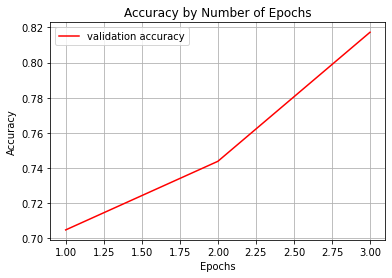

In [ ]:
### Use Glove Pretrained Embeddings - UNFROZEN ###
model_pretrained_unfrozen = NNPOSTagger(window_size=WINDOW_SIZE,
                                        vocab_size=len(vocab_words),
                                        embedding_dim=300,
                                        hidden_dim=128,
                                        output_dim=len(vocab_ud),
                                        nonlinearity=nn.Tanh(),
                                        use_glove=True,
                                        freeze_glove=False).to(device)

optimizer_pretrained_unfrozen = torch.optim.Adam(
    model_pretrained_unfrozen.parameters(), lr=1e-4)


def train_an_epoch_pretrained_unfrozen(dataloader):
    model_pretrained_unfrozen.train()  # Sets the module in training mode.
    log_interval = 500

    for idx, (label, text) in enumerate(dataloader):
        # reset gradients to zero since torch accumulates gradients.
        model_pretrained_unfrozen.zero_grad()
        log_probs = model_pretrained_unfrozen(text)  # run forward pass
        loss = loss_function(log_probs, label)
        loss.backward()  # run backward pass to update the gradient
        optimizer_pretrained_unfrozen.step()
        if idx % log_interval == 0 and idx > 0:
            print(f'At iteration {idx} the loss is {loss:.3f}.')


def get_accuracy_pretrained_unfrozen(dataloader):
    model_pretrained_unfrozen.eval()
    with torch.no_grad():
        total_acc, total_count = 0, 0
        for idx, (label, word_idxs) in enumerate(dataloader):
            log_probs = model_pretrained_unfrozen(word_idxs)
            total_acc += (log_probs.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count


accuracies = []
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train_an_epoch_pretrained_unfrozen(train_dataloader)
    accuracy = get_accuracy_pretrained_unfrozen(valid_dataloader)
    accuracies.append(accuracy)
    time_taken = time.time() - epoch_start_time
    print(
        f'Epoch: {epoch}, time taken: {time_taken:.1f}s, validation accuracy: {accuracy:.3f}.')

plt.title("Accuracy by Number of Epochs")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.grid()
plt.plot(range(1, EPOCHS+1), accuracies, "r", label="validation accuracy")
plt.legend()
plt.savefig(f"POSValidationAccuracyPretrainedUnfrozen{EPOCHS}epochs.jpg")


### Optionally extending the model

**Task 8** [0]: This is an optional, open-ended task.   Try three different ways of your choosing to improve the performance of the model. You may want to vary w, or add additional layers to the network, or increase the size of the hidden vectors $h$, or try with different activation functions. Report on the results you get. Do you think your POS tagger is comparable to a human tagger?



In [ ]:
'''
Results after varying w:
Results after doing....:
Results after doing...:
'''

'\nResults after varying w:\nResults after doing....:\nResults after doing...:\n'